### We do convergence vs CPU-time for general multiplicative noise 10 times smaller than done previously

In [11]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
from jax import vmap
import time

config.update("jax_enable_x64", True)
import scienceplots
plt.style.use(['science','ieee'])

In [12]:
key1 = jax.random.PRNGKey(0)
i=8
nmax = int(400 * 2**i) #10000
tmax = 4.0 # 0.1 timestep
dt = 0.001**(1/2)**i # tmax/nmax
E=1; P=3
dW = jax.random.normal(key1, shape=(nmax, E, P))
print(dW.shape)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0, i+1):
    nmax = int(400 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()
#time_refine.reverse()
print(nmax,len(time_refine[0]),len(W_refine[0]))
print(len(time_refine[-1]),len(W_refine[-1]))

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)

array = jnp.zeros(8)
nmax = int(400 * 2**i) 
tmax = 4.0
dt = 0.001*(1/2)**i
key = jax.random.PRNGKey(0)

(102400, 1, 3)
102400 400 400
102400 102400


In [ ]:
methods = ['Dealiased_IFSRK4','Dealiased_SETDRK4','Dealiased_SRK4']
max_number = 14
array = jnp.zeros([len(methods),max_number])
cpu_times_array = jnp.zeros([len(methods),max_number])

total_array = jnp.zeros([9,max_number])
total_cpu_array = jnp.zeros([9,max_number])# 9 methods, 9 
key = jax.random.PRNGKey(0)
nmax = int(400 * 2**max_number)# highest resolution is 100 2^{16} timestes
tmax = 4.0 
dt = 0.01*(1/2)**max_number
assert dt*nmax == tmax, "dt*nmax must equal tmax for the setup to be correct."
E=1; P=3
dW = jax.random.normal(key, shape=(nmax, E, P))

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0,max_number+1):
    nmax = int(400 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()

# generate the analytic solution
signal_params = ConfigDict(KDV_params_2_SALT)
signal_params.update(E=1,method='Dealiased_SETDRK4',dt= 0.01*(1/2)**max_number, nt = int(400 * 2**max_number),tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.05,Advection_basis_name='sin')
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
dW =(dW_refine[max_number]/jnp.sqrt(2**(max_number-max_number)))
analytic_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
del signal_model

for j, method in enumerate(methods):
    for i in range(max_number):
        print(i,method)
        signal_params = ConfigDict(KDV_params_2_SALT)
        signal_params.update(E=1,method=method,dt = 0.01*(1/2)**i, nt = int(400 * 2**i) ,tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.05,Advection_basis_name='sin')
        signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
        initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
        dW =(dW_refine[i]/jnp.sqrt(2**(max_number-i))) # renormalise. from the refined dW created.
        num_runs = 5
        times = []
        for _ in range(num_runs):
            start = time.time()
            _ = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key).block_until_ready()
            times.append(time.time() - start)
        avg_time = sum(times) / num_runs
        print(f"Average CPU time for i={i}: {avg_time:.4f} seconds")
        # Save to an array indexed by i
        cpu_times_array = cpu_times_array.at[j,i].set(avg_time)        
        signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
        
        
        ans = relative_error_final(signal_final[0,:], analytic_final[0,:])
        print("relative error",ans)
        array = array.at[j,i].set(ans)
        del signal_model
        del signal_params
        print("done",j,i,method)

for j in range(len(methods)):
    total_array = total_array.at[j,:].set(array[j,:])
    total_cpu_array = total_cpu_array.at[j,:].set(cpu_times_array[j,:])

0 Dealiased_IFSRK4
Average CPU time for i=0: 0.0717 seconds
relative error nan
done 0 0 Dealiased_IFSRK4
1 Dealiased_IFSRK4
Average CPU time for i=1: 0.0783 seconds
relative error nan
done 0 1 Dealiased_IFSRK4
2 Dealiased_IFSRK4
Average CPU time for i=2: 0.0921 seconds
relative error nan
done 0 2 Dealiased_IFSRK4
3 Dealiased_IFSRK4
Average CPU time for i=3: 0.1214 seconds
relative error 1.0915721709196566
done 0 3 Dealiased_IFSRK4
4 Dealiased_IFSRK4
Average CPU time for i=4: 0.1812 seconds
relative error 1.293619520242839
done 0 4 Dealiased_IFSRK4
5 Dealiased_IFSRK4
Average CPU time for i=5: 0.2915 seconds
relative error 1.2209818740722427
done 0 5 Dealiased_IFSRK4
6 Dealiased_IFSRK4
Average CPU time for i=6: 0.5230 seconds
relative error 1.0573216082732797
done 0 6 Dealiased_IFSRK4
7 Dealiased_IFSRK4
Average CPU time for i=7: 0.9881 seconds
relative error 0.845642521169993
done 0 7 Dealiased_IFSRK4
8 Dealiased_IFSRK4
Average CPU time for i=8: 1.9215 seconds
relative error 0.7311917876

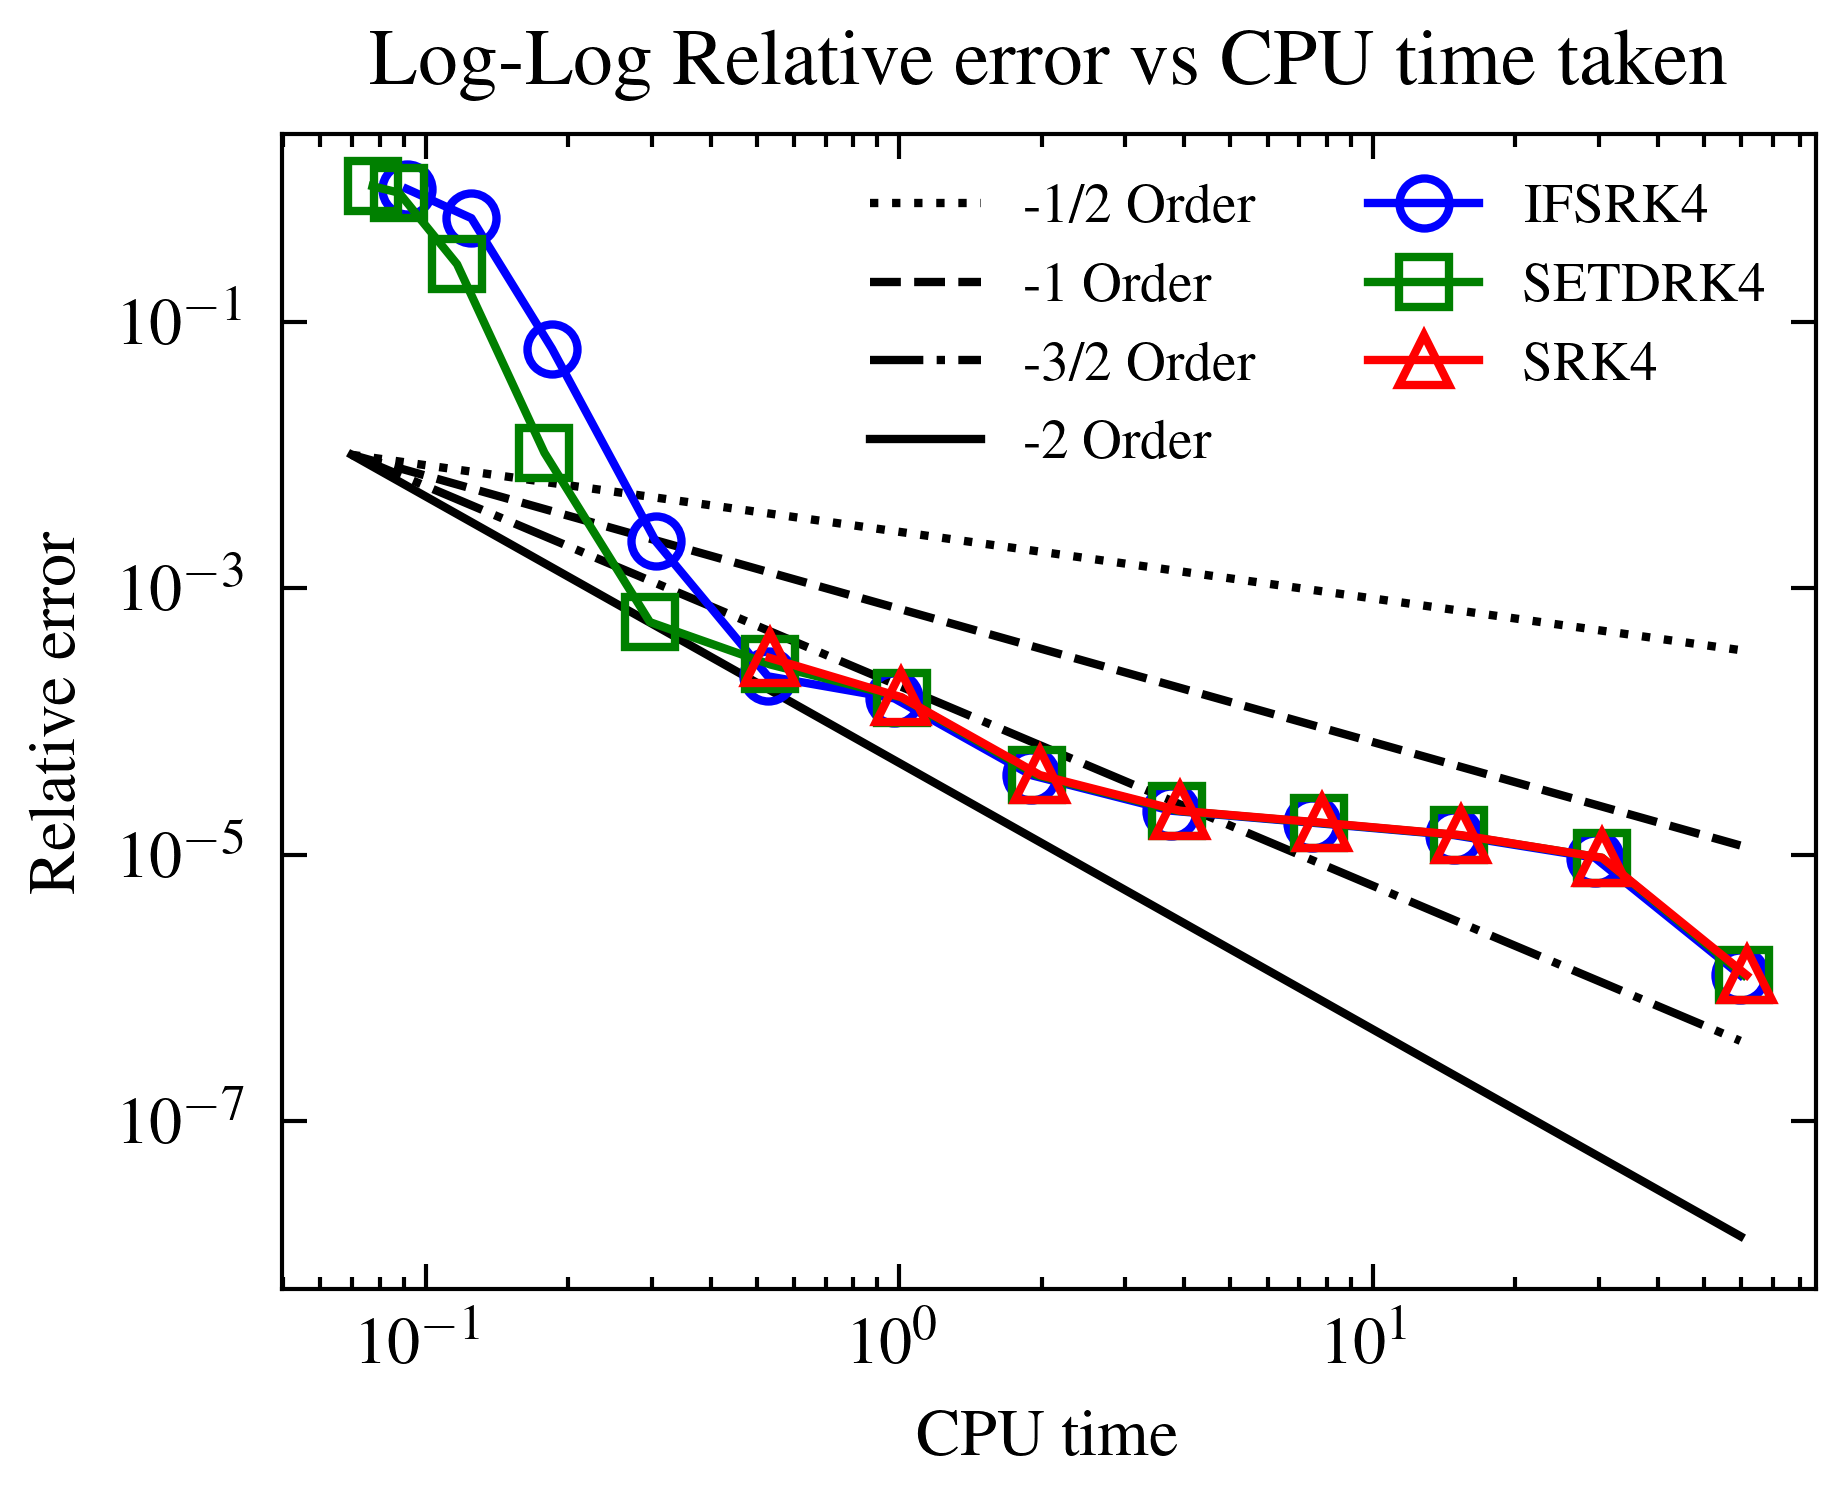

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])

values = array
a = cpu_times_array[0,0]
v= 1e-2
plt.figure()
# Mask values greater than 1 before plotting
# values = np.where(values > 2, np.nan, values)
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-0.5)/(a**-0.5)*v, linestyle=':', color='k', label=r'-1/2 Order')
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-1)/(a**-1)*v, linestyle='--', color='k', label=r'-1 Order')
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-1.5)/(a**-1.5)*v, linestyle='-.', color='k', label=r'-3/2 Order')
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-2)/(a**-2)*v, linestyle='-', color='k', label=r'-2 Order')

marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p', 'H', 'd', 'X']
color_list = ['b', 'g', 'r', 'c', 'm', 'y']
methods = ['Dealiased_IFSRK4','Dealiased_SETDRK4','Dealiased_SRK4']

# In matplotlib, the marker for an upward-pointing triangle is '^'
for j, method in enumerate(methods):
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    plt.loglog(cpu_times_array[j,:], total_array[j, :], marker=marker,color=color, linestyle='-', label=f'{method.replace("Dealiased_", "")}', markerfacecolor='none')

plt.xlabel(f'CPU time')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error vs CPU time taken')
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
#plt.grid(True, which="both", ls="--")
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/EX5_SG_cpu_error_RK4_IFRK4_ETDRK4.png',bbox_inches='tight',dpi=300)
plt.show()

In [ ]:
methods = ['Dealiased_eSSPIFSRK_P_33','Dealiased_SETDRK33','Dealiased_SSP33']
max_number = 14
array = jnp.zeros([len(methods),max_number])
cpu_times_array_2 = jnp.zeros([len(methods),max_number])
key = jax.random.PRNGKey(0)
nmax = int(400 * 2**max_number)
tmax = 4.0
dt = 0.01*(1/2)**max_number
assert dt*nmax == tmax, "dt*nmax must equal tmax for the setup to be correct."
E=1; P=3
dW = jax.random.normal(key, shape=(nmax, E, P))

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0,max_number+1):
    nmax = int(400 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()


# generate the analytic solution
signal_params = ConfigDict(KDV_params_2_SALT)
signal_params.update(E=1,method='Dealiased_SETDRK4',dt= 0.01*(1/2)**max_number, nt = int(400 * 2**max_number),tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.05,Advection_basis_name='sin')
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
dW =(dW_refine[max_number]/jnp.sqrt(2**(max_number-max_number)))
analytic_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
del signal_model

for j, method in enumerate(methods):
    for i in range(max_number):
        print(i,method)
        signal_params = ConfigDict(KDV_params_2_SALT)
        signal_params.update(E=1,method=method,dt = 0.01*(1/2)**i, nt = int(400 * 2**i) ,tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.05,Advection_basis_name='sin')
        signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
        initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
        dW =(dW_refine[i]/jnp.sqrt(2**(max_number-i))) # renormalise. from the refined dW created.
        num_runs = 5
        times = []
        for _ in range(num_runs):
            start = time.time()
            _ = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key).block_until_ready()
            times.append(time.time() - start)
        avg_time = sum(times) / num_runs
        print(f"Average CPU time for i={i}: {avg_time:.4f} seconds")
        # Save to an array indexed by i
        cpu_times_array_2 = cpu_times_array_2.at[j,i].set(avg_time)        
        signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
        
        
        ans = relative_error_final(signal_final[0,:], analytic_final[0,:])
        print("relative error",ans)
        array = array.at[j,i].set(ans)
        del signal_model
        del signal_params
        print("done",j,i,method)


for j in range(len(methods)):
    total_array = total_array.at[j+3,:].set(array[j,:])
    total_cpu_array = total_cpu_array.at[j+3,:].set(cpu_times_array_2[j,:])


0 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=0: 0.0736 seconds
relative error nan
done 0 0 Dealiased_eSSPIFSRK_P_33
1 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=1: 0.0802 seconds
relative error nan
done 0 1 Dealiased_eSSPIFSRK_P_33
2 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=2: 0.0922 seconds
relative error nan
done 0 2 Dealiased_eSSPIFSRK_P_33
3 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=3: 0.1131 seconds
relative error 0.9827425035929629
done 0 3 Dealiased_eSSPIFSRK_P_33
4 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=4: 0.1622 seconds
relative error 0.6341614883099006
done 0 4 Dealiased_eSSPIFSRK_P_33
5 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=5: 0.2569 seconds
relative error 0.17949566329153896
done 0 5 Dealiased_eSSPIFSRK_P_33
6 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=6: 0.4435 seconds
relative error 0.023892289488449365
done 0 6 Dealiased_eSSPIFSRK_P_33
7 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=7: 0.8136 seconds
relative error 0.00292

[[6.98306084e-02 7.75405407e-02 9.13233757e-02 1.24980211e-01
  1.84875917e-01 3.06422615e-01 5.28248358e-01 9.76889038e-01
  1.90222707e+00 3.74937649e+00 7.44901824e+00 1.48443192e+01
  2.94550435e+01 5.97285386e+01]
 [6.60636902e-02 7.72900105e-02 8.78821373e-02 1.16564751e-01
  1.78229427e-01 2.97707462e-01 5.33624411e-01 1.01285391e+00
  1.95070677e+00 3.85959821e+00 7.69695845e+00 1.52342937e+01
  3.04866110e+01 6.07094948e+01]
 [6.40114307e-02 7.25698471e-02 8.79364014e-02 1.19338655e-01
  1.78216362e-01 3.01959467e-01 5.32883310e-01 1.01101193e+00
  1.98449106e+00 3.91106753e+00 7.83029580e+00 1.53823154e+01
  3.04839353e+01 6.16134735e+01]
 [7.36345768e-02 8.01552773e-02 9.22386646e-02 1.13130951e-01
  1.62166882e-01 2.56897736e-01 4.43489742e-01 8.13555908e-01
  1.56527376e+00 3.10228181e+00 6.12839794e+00 1.21971699e+01
  2.39984052e+01 4.73758379e+01]
 [6.27733707e-02 6.85723782e-02 8.87226582e-02 1.03780460e-01
  1.50484085e-01 2.55391836e-01 4.38377142e-01 8.13632774e-01


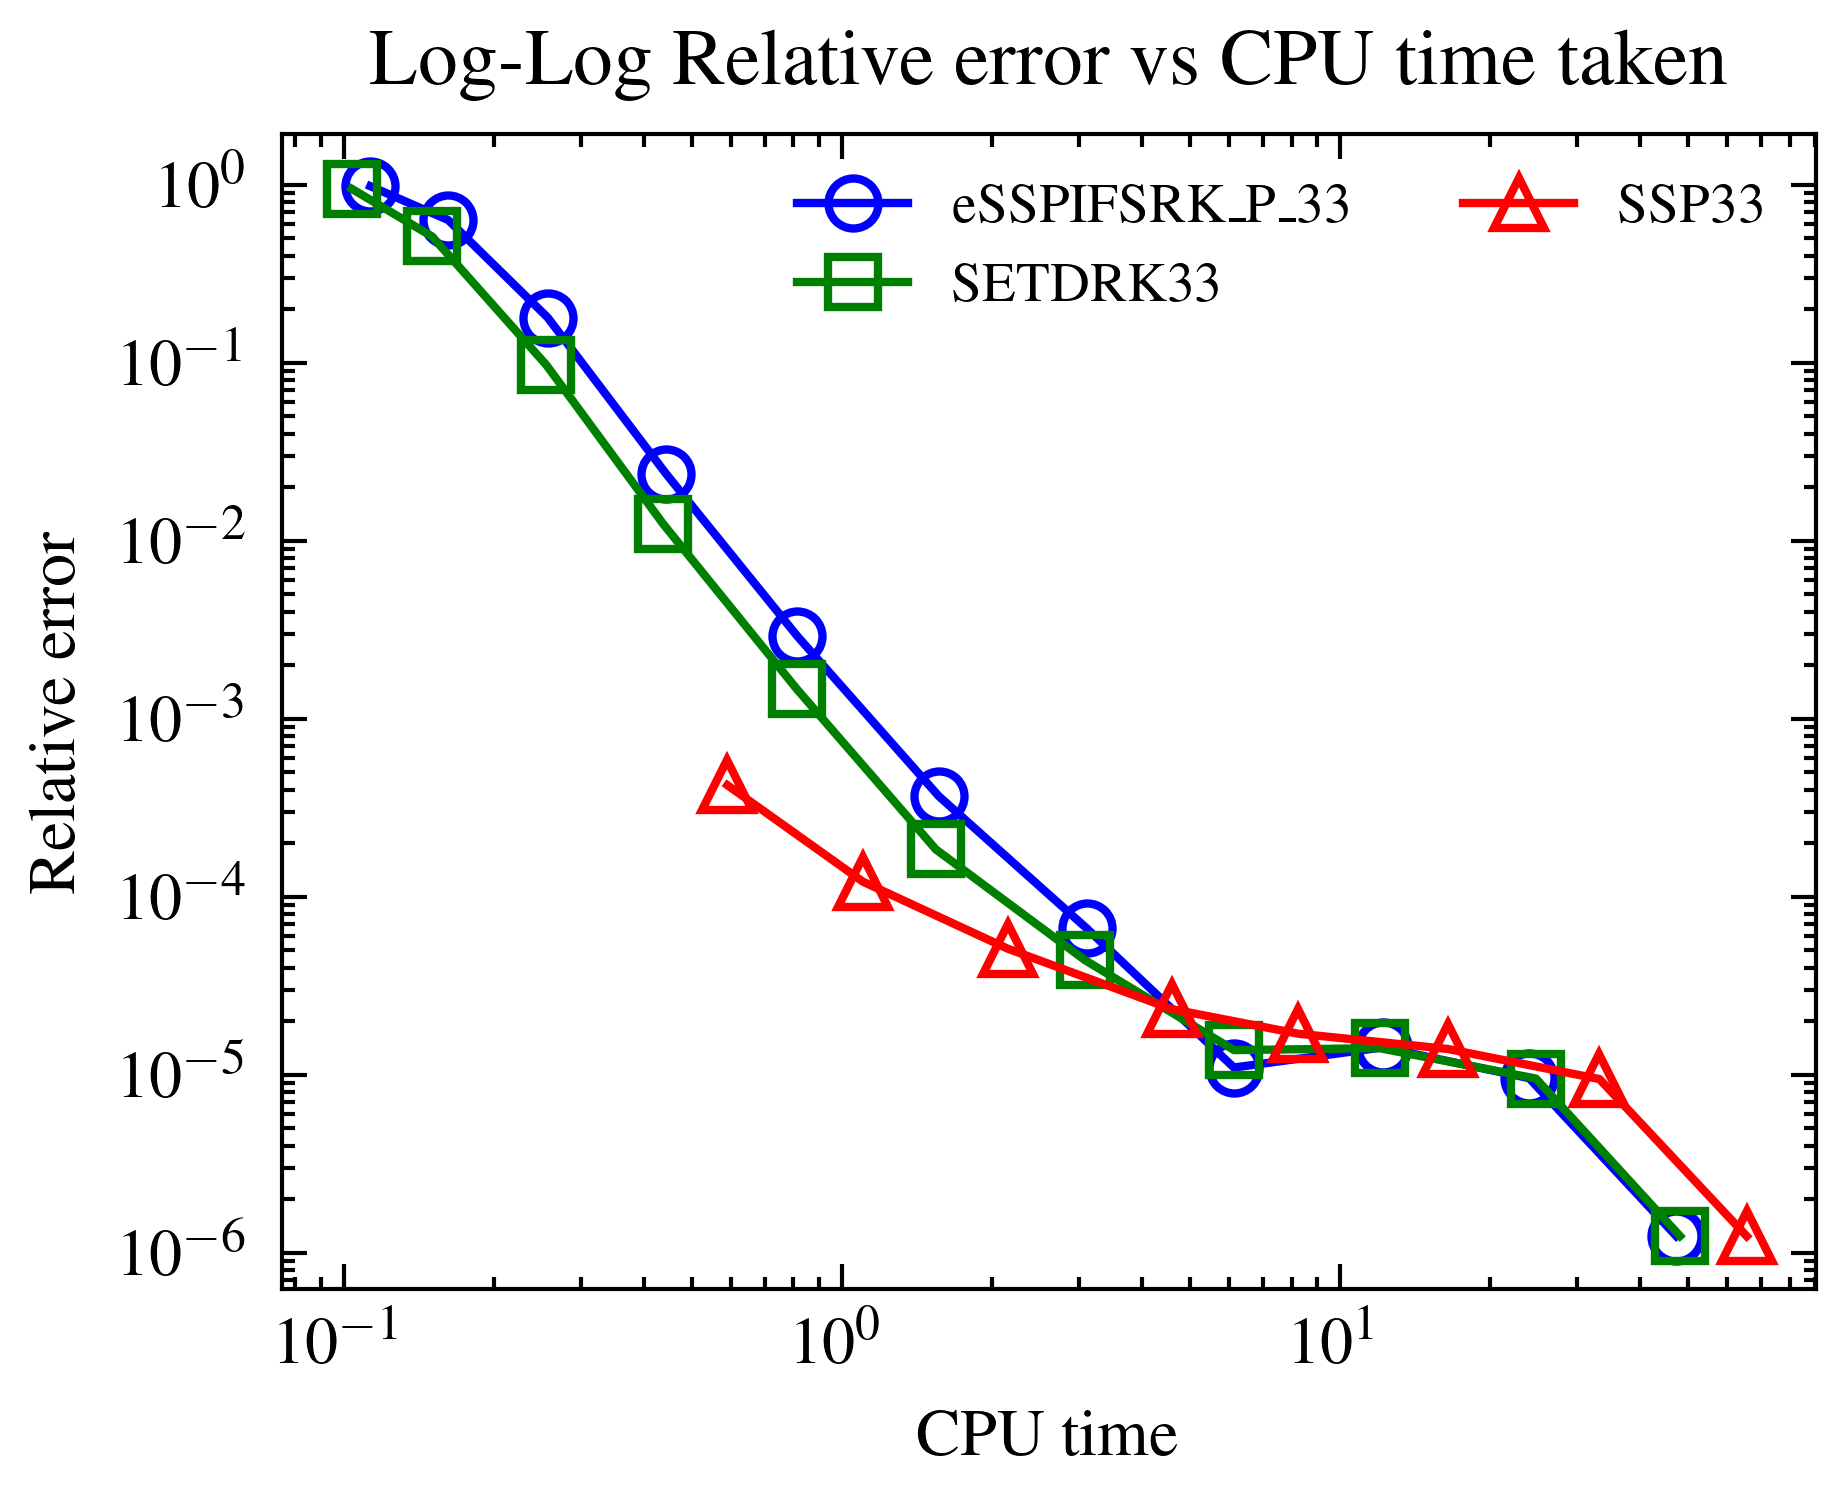

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
#dt = cpu_times_array#1e-3*np.asarray([2**-i for i in range(0,max_number)])
methods = ['Dealiased_eSSPIFSRK_P_33','Dealiased_SETDRK33','Dealiased_SSP33']

values = total_array[3:6,:]
cpu_times_array_2 = total_cpu_array[3:6, :]
print(total_cpu_array)
# v= 1e-2
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
# Mask values greater than 1 before plotting
# values = np.where(values > 2, np.nan, values)
# plt.loglog(cpu_times_array_2[0,:],(cpu_times_array_2[0,:]**-0.5)/(a**-0.5)*v, linestyle=':', color='k', label=r'-1/2 Order')
# plt.loglog(cpu_times_array_2[0,:],(cpu_times_array_2[0,:]**-1)/(a**-1)*v, linestyle='--', color='k', label=r'-1 Order')
# plt.loglog(cpu_times_array_2[0,:],(cpu_times_array_2[0,:]**-1.5)/(a**-1.5)*v, linestyle='-.', color='k', label=r'-3/2 Order')
# plt.loglog(cpu_times_array_2[0,:],(cpu_times_array_2[0,:]**-2)/(a**-2)*v, linestyle='-', color='k', label=r'-2 Order')

marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p', 'H', 'd', 'X']
color_list = ['b', 'g', 'r', 'c', 'm', 'y']
# In matplotlib, the marker for an upward-pointing triangle is '^'
for j, method in enumerate(methods):
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    plt.loglog(cpu_times_array_2[j,:], values[j,:], marker=marker,color=color, linestyle='-', label=f'{method.replace("Dealiased_", "")}', markerfacecolor='none')

plt.xlabel(f'CPU time')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error vs CPU time taken')
#plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
#plt.grid(True, which="both", ls="--")
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/EX5_SG_cpu_error_SSP33_IFRK3_SETDRK3.png',bbox_inches='tight',dpi=300)
plt.show()

In [ ]:
methods = ['Dealiased_eSSPIFSRK_P_22','Dealiased_SETDRK22','Dealiased_SSP22']
max_number = 14
array = jnp.zeros([len(methods),max_number])
cpu_times_array_3 = jnp.zeros([len(methods),max_number])
key = jax.random.PRNGKey(0)
nmax = int(400 * 2**max_number)
tmax = 4.0 
dt = 0.01*(1/2)**max_number
assert dt*nmax == tmax, "dt*nmax must equal tmax for the setup to be correct."
E=1; P=3
dW = jax.random.normal(key, shape=(nmax, E, P))

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0,max_number+1):
    nmax = int(400 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()



# generate the analytic solution
signal_params = ConfigDict(KDV_params_2_SALT)
signal_params.update(E=1,method='Dealiased_SETDRK4',dt= 0.01*(1/2)**max_number, nt = int(400 * 2**max_number),tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.05,Advection_basis_name='sin')
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
dW =(dW_refine[max_number]/jnp.sqrt(2**(max_number-max_number)))
analytic_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
del signal_model

for j, method in enumerate(methods):
    for i in range(max_number):
        print(i,method)
        signal_params = ConfigDict(KDV_params_2_SALT)
        signal_params.update(E=1,method=method,dt = 0.01*(1/2)**i, nt = int(400 * 2**i) ,tmax=4.0,nx=256,P=3,S=0,noise_magnitude=0.05,Advection_basis_name='sin')
        signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
        initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
        dW =(dW_refine[i]/jnp.sqrt(2**(max_number-i))) # renormalise. from the refined dW created.
        num_runs = 5
        times = []
        for _ in range(num_runs):
            start = time.time()
            _ = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key).block_until_ready()
            times.append(time.time() - start)
        avg_time = sum(times) / num_runs
        print(f"Average CPU time for i={i}: {avg_time:.4f} seconds")
        # Save to an array indexed by i
        cpu_times_array_3 = cpu_times_array_3.at[j,i].set(avg_time)        
        signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
        
        
        ans = relative_error_final(signal_final[0,:], analytic_final[0,:])
        print("relative error",ans)
        array = array.at[j,i].set(ans)
        del signal_model
        del signal_params
        print("done",j,i,method)


for j in range(len(methods)):
    total_array = total_array.at[j+6,:].set(array[j,:])
    total_cpu_array = total_cpu_array.at[j+6,:].set(cpu_times_array_3[j,:])


0 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=0: 0.0634 seconds
relative error nan
done 0 0 Dealiased_eSSPIFSRK_P_22
1 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=1: 0.0924 seconds
relative error nan
done 0 1 Dealiased_eSSPIFSRK_P_22
2 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=2: 0.0695 seconds
relative error nan
done 0 2 Dealiased_eSSPIFSRK_P_22
3 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=3: 0.0893 seconds
relative error nan
done 0 3 Dealiased_eSSPIFSRK_P_22
4 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=4: 0.1228 seconds
relative error nan
done 0 4 Dealiased_eSSPIFSRK_P_22
5 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=5: 0.1887 seconds
relative error 0.818711908043151
done 0 5 Dealiased_eSSPIFSRK_P_22
6 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=6: 0.3305 seconds
relative error 0.1747783377254275
done 0 6 Dealiased_eSSPIFSRK_P_22
7 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=7: 0.7176 seconds
relative error 0.023894100229692076
done 0 7 Dealiased_e

[[           nan            nan            nan            nan
             nan 8.18711908e-01 1.74778338e-01 2.38941002e-02
  3.51556030e-03 5.59656578e-04 1.25896854e-04 2.86979983e-05
  9.11034429e-06 2.52841339e-06]
 [           nan            nan            nan            nan
  9.52852897e-01 3.45123225e-01 4.90216046e-02 7.34365136e-03
  1.22133148e-03 2.12996047e-04 6.68150797e-05 2.00534369e-05
  9.02540524e-06 2.07740379e-06]
 [           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan 1.09481887e-04 3.07514148e-05
  1.16554327e-05 2.30099244e-06]]
(3, 14)
[[           nan            nan            nan            nan
             nan 8.18711908e-01 1.74778338e-01 2.38941002e-02
  3.51556030e-03 5.59656578e-04 1.25896854e-04 2.86979983e-05
  9.11034429e-06 2.52841339e-06]
 [           nan            nan            nan            nan
  9.52852897e-01 3.45123225e-01 4.90216046e-02 7.3436

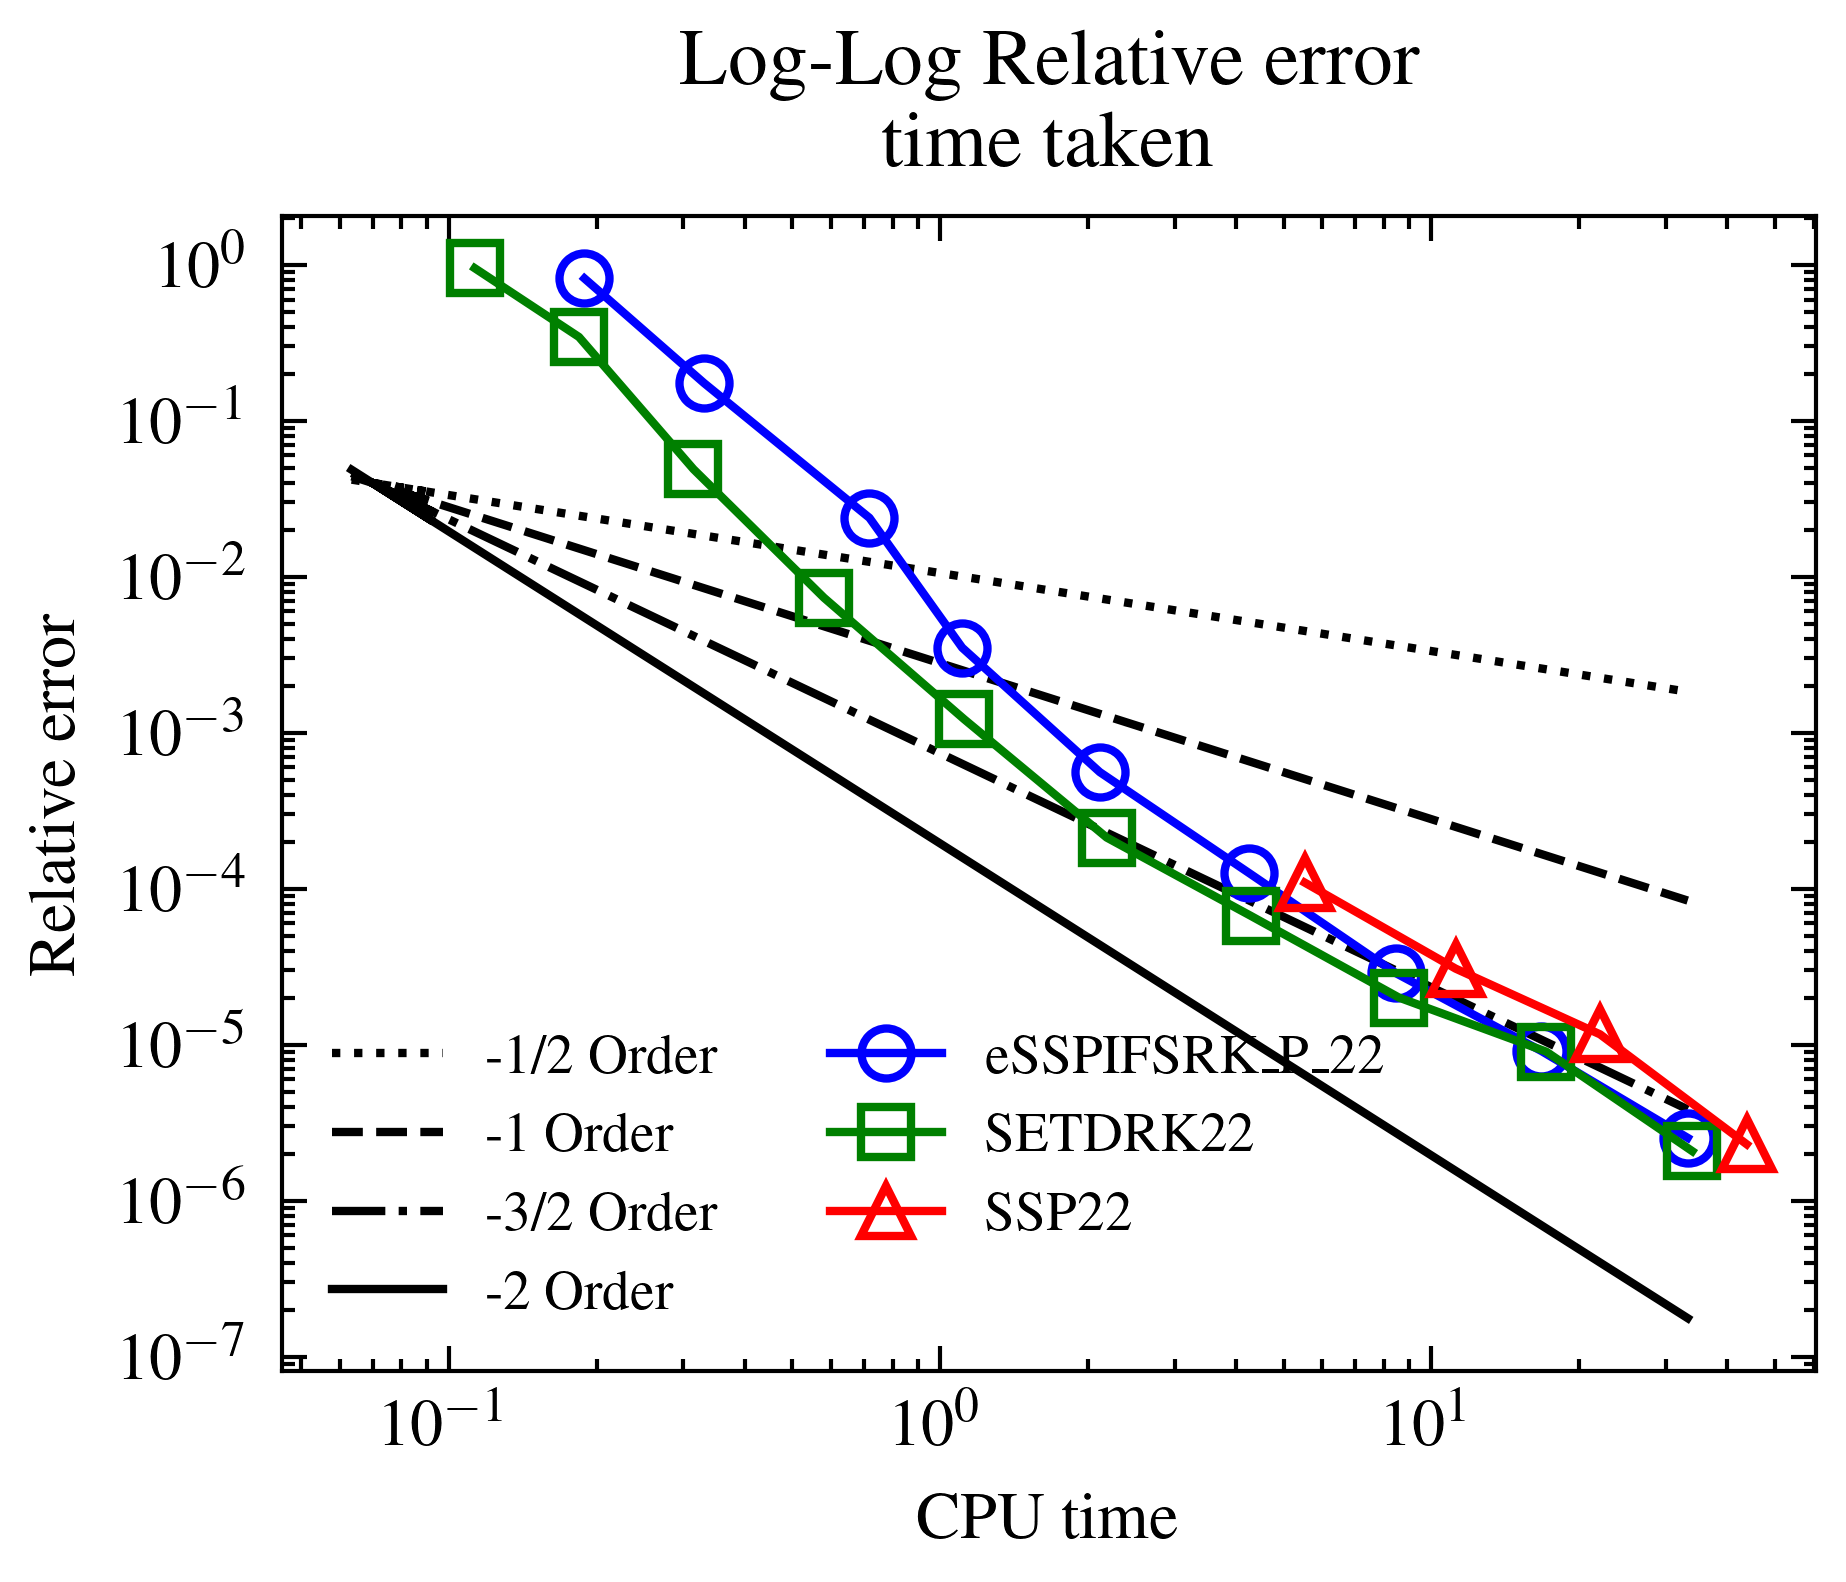

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
methods = ['Dealiased_eSSPIFSRK_P_22','Dealiased_SETDRK22','Dealiased_SSP22']
values = array
print(values)
print(values.shape)
values = array
print(values,values.shape)
a = cpu_times_array[0,0]
v= 4e-2
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
# Mask values greater than 1 before plotting
# values = np.where(values > 2, np.nan, values)
plt.loglog(cpu_times_array_3[0,:],(cpu_times_array_3[0,:]**-0.5)/(a**-0.5)*v, linestyle=':', color='k', label=r'-1/2 Order')
plt.loglog(cpu_times_array_3[0,:],(cpu_times_array_3[0,:]**-1)/(a**-1)*v, linestyle='--', color='k', label=r'-1 Order')
plt.loglog(cpu_times_array_3[0,:],(cpu_times_array_3[0,:]**-1.5)/(a**-1.5)*v, linestyle='-.', color='k', label=r'-3/2 Order')
plt.loglog(cpu_times_array_3[0,:],(cpu_times_array_3[0,:]**-2)/(a**-2)*v, linestyle='-', color='k', label=r'-2 Order')

marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p', 'H', 'd', 'X']
color_list = ['b', 'g', 'r', 'c', 'm', 'y']
# In matplotlib, the marker for an upward-pointing triangle is '^'
for j, method in enumerate(methods):
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    plt.loglog(cpu_times_array_3[j,:], values[j, :], marker=marker,color=color, linestyle='-', label=f'{method.replace("Dealiased_", "")}', markerfacecolor='none')

plt.xlabel(f'CPU time')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error \n time taken')
#plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
#plt.grid(True, which="both", ls="--")
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/EX5_SG_cpu_error_SSP22_IFRK2_ETD2.png',bbox_inches='tight',dpi=300)
plt.show()




[[           nan            nan            nan            nan
             nan 8.18711908e-01 1.74778338e-01 2.38941002e-02
  3.51556030e-03 5.59656578e-04 1.25896854e-04 2.86979983e-05
  9.11034429e-06 2.52841339e-06]
 [           nan            nan            nan            nan
  9.52852897e-01 3.45123225e-01 4.90216046e-02 7.34365136e-03
  1.22133148e-03 2.12996047e-04 6.68150797e-05 2.00534369e-05
  9.02540524e-06 2.07740379e-06]
 [           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan 1.09481887e-04 3.07514148e-05
  1.16554327e-05 2.30099244e-06]]
(3, 14)
[[           nan            nan            nan            nan
             nan 8.18711908e-01 1.74778338e-01 2.38941002e-02
  3.51556030e-03 5.59656578e-04 1.25896854e-04 2.86979983e-05
  9.11034429e-06 2.52841339e-06]
 [           nan            nan            nan            nan
  9.52852897e-01 3.45123225e-01 4.90216046e-02 7.3436

<Figure size 1980x1500 with 0 Axes>

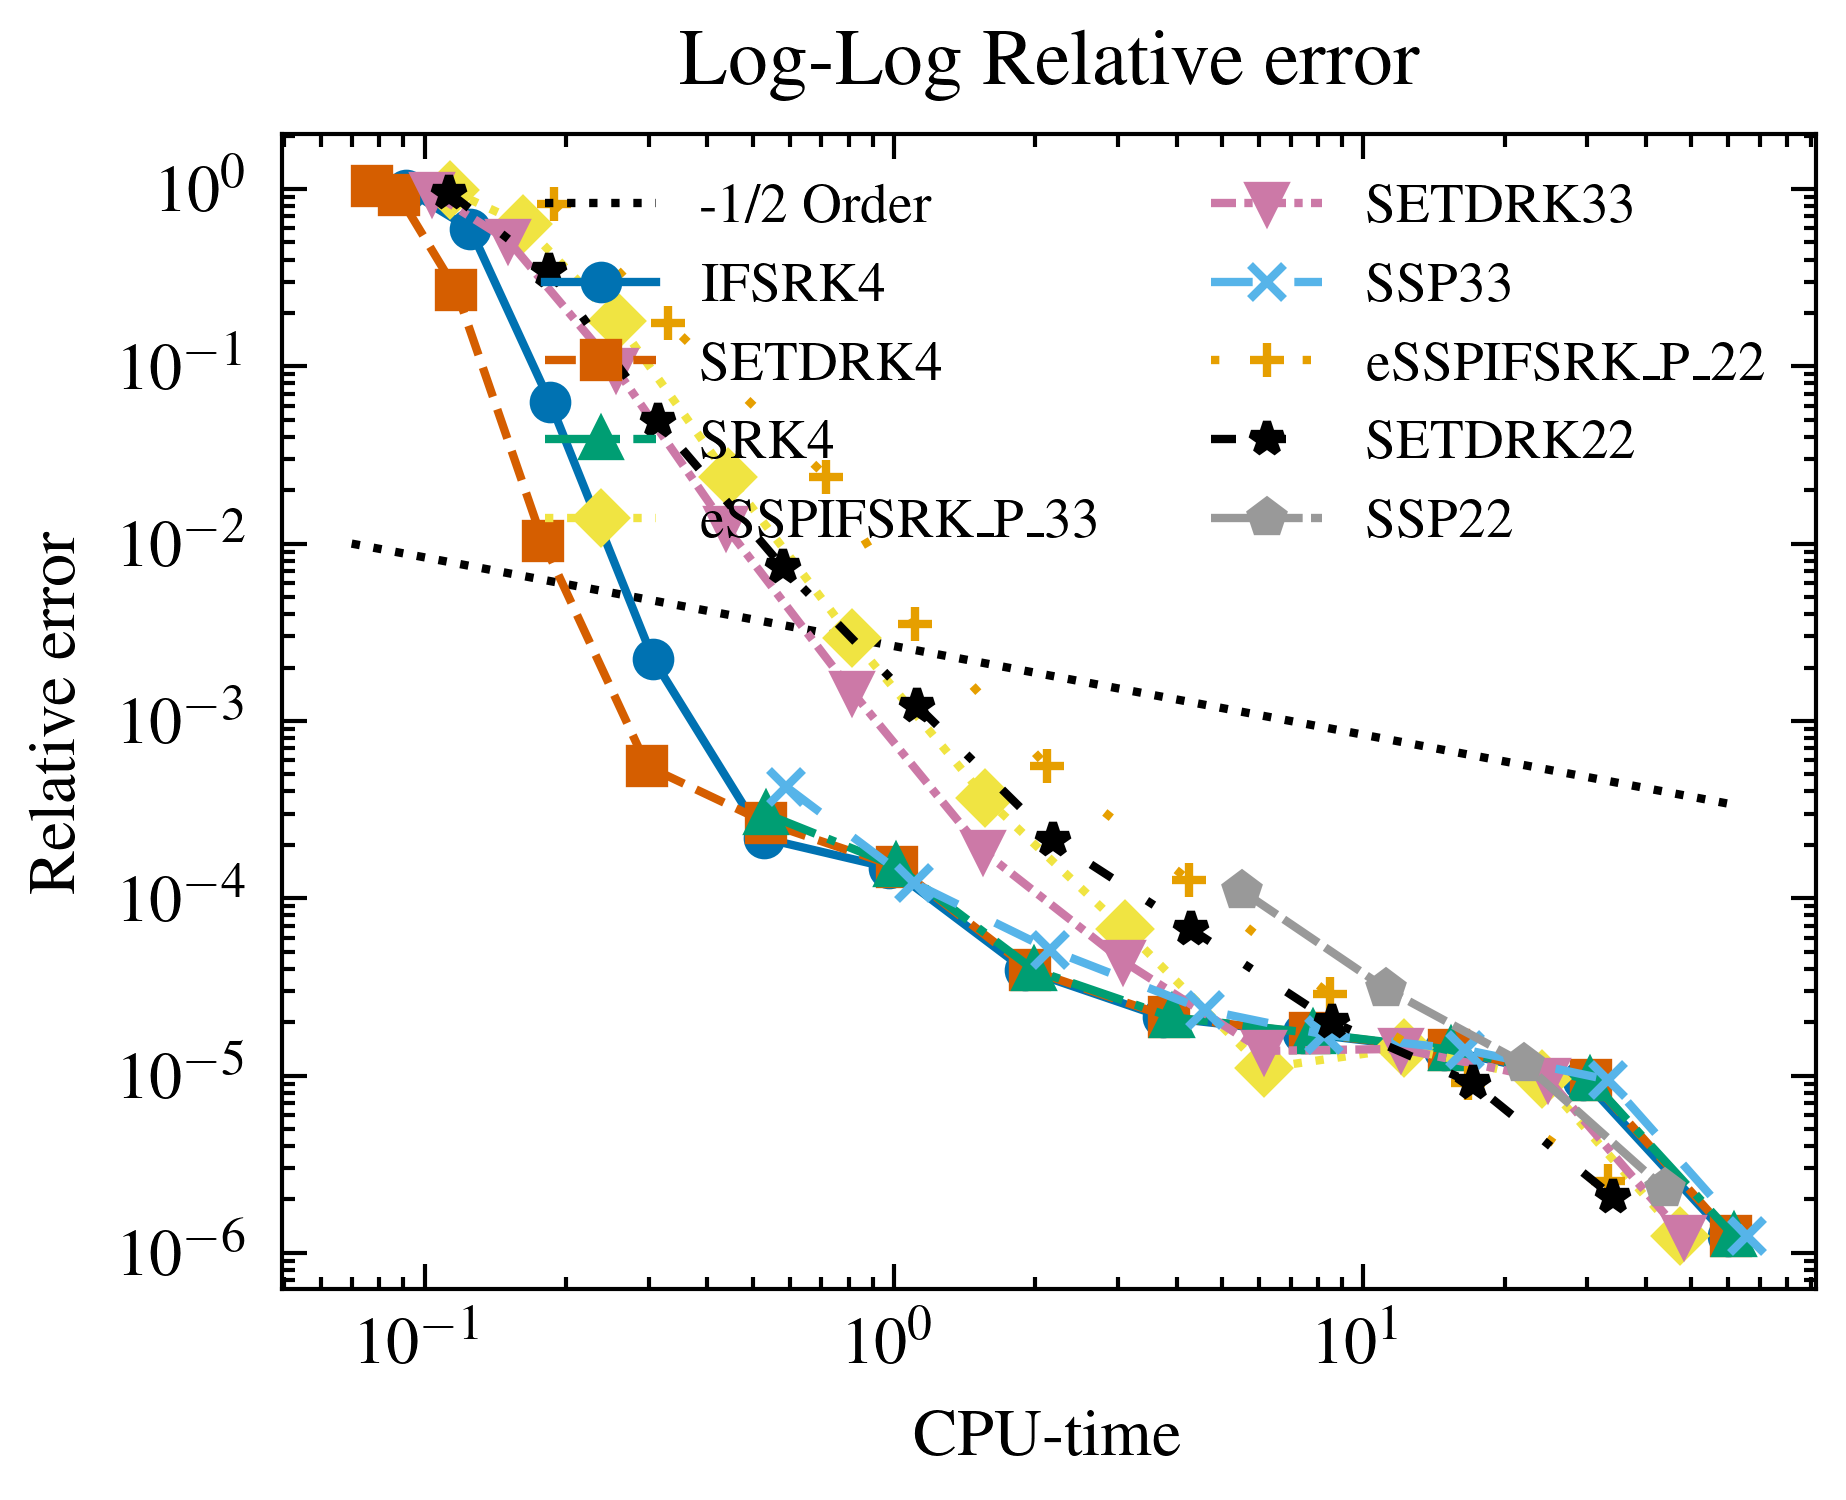

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
plt.clf()
methods = ['Dealiased_IFSRK4','Dealiased_SETDRK4','Dealiased_SRK4',
           'Dealiased_eSSPIFSRK_P_33','Dealiased_SETDRK33','Dealiased_SSP33',
           'Dealiased_eSSPIFSRK_P_22','Dealiased_SETDRK22','Dealiased_SSP22']
max_number = 14
dt = 0.01*np.asarray([2**-i for i in range(0,max_number)])
values = array
print(values)
print(values.shape)
values = array
print(values,values.shape)
a = cpu_times_array[0,0]*4#
v= 5e-3#
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
# Mask values greater than 1 before plotting
values = np.where(values > 1, np.nan, values)
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-0.5)/(a**-0.5)*v, linestyle=':', color='k', label=r'-1/2 Order')
# plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-1)/(a**-1)*v, linestyle='--', color='k', label=r'-1 Order')
# plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-1.5)/(a**-1.5)*v, linestyle='-.', color='k', label=r'-3/2 Order')
# plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-2)/(a**-2)*v, linestyle='-', color='k', label=r'-2 Order')


marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p']
# Use a colorblind-friendly palette for better accessibility
color_list = [
    "#0072B2",  # Blue
    "#D55E00",  # Vermillion
    "#009E73",  # Green
    "#F0E442",  # Yellow
    "#CC79A7",  # Purple
    "#56B4E9",  # Sky Blue
    "#E69F00",  # Orange
    "#000000",  # Black
    "#999999"   # Grey
]
#color_list = ["#0d23e8", "#32e80d", "#e81c0d", "#0da6e8", "#c4e80d", "#e85a0d",  "#24a3a5", "#98a524", "#a0792c"]
linestyle_list = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 10)), (0, (3, 5, 1, 5)), (0, (5, 1))]
# In matplotlib, the marker for an upward-pointing triangle is '^'
for j, method in enumerate(methods):
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    linestyle = linestyle_list[j % len(linestyle_list)]
    plt.loglog(total_cpu_array[j,:], total_array[j, :], marker=marker, color=color, linestyle=linestyle, label=f'{method.replace("Dealiased_", "")}',  markersize=4)
    #plt.loglog(dt, total_array[j, :], marker=marker,color=color, linestyle=linestyle, label=f'{method.replace("Dealiased_", "")}')

plt.xlabel('CPU-time')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error')
#plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
#plt.grid(True, which="both", ls="--")

plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/EX5_SG_cpu_time_Allatty.png',bbox_inches='tight',dpi=300)
plt.show()

<Figure size 1980x1500 with 0 Axes>

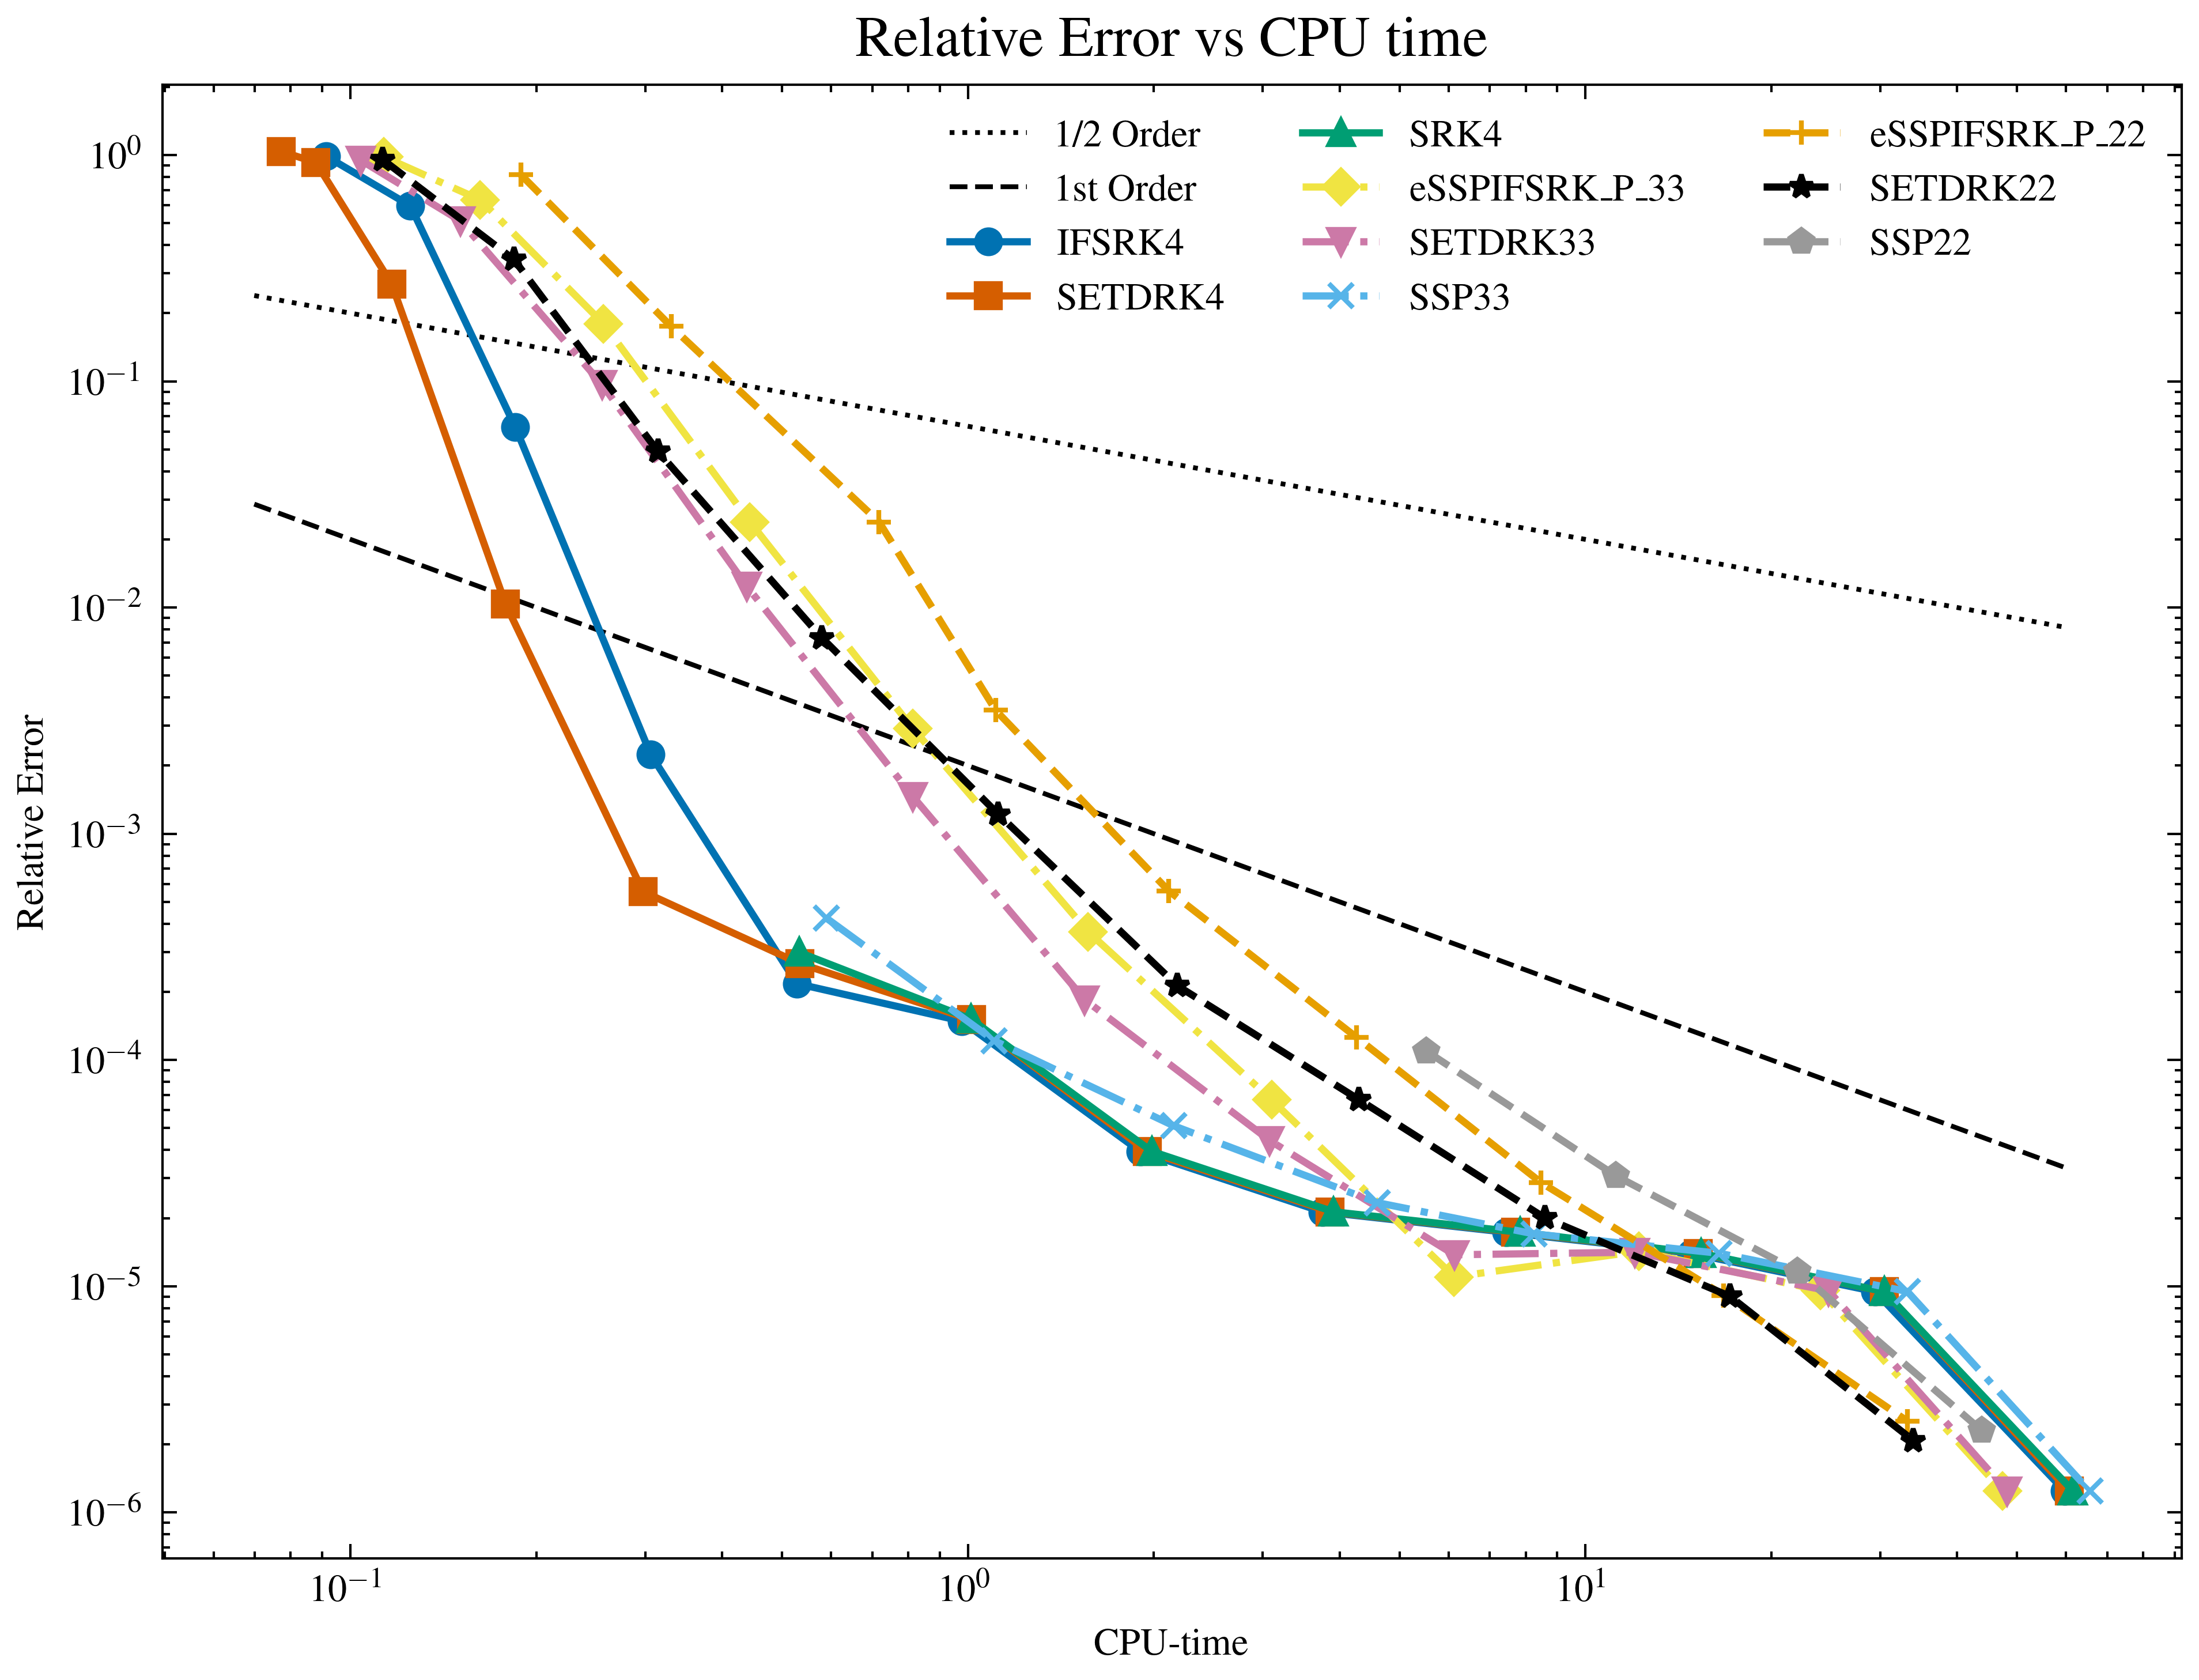

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])

# --- Inputs ---
methods = [
    'Dealiased_IFSRK4', 'Dealiased_SETDRK4', 'Dealiased_SRK4',
    'Dealiased_eSSPIFSRK_P_33', 'Dealiased_SETDRK33', 'Dealiased_SSP33',
    'Dealiased_eSSPIFSRK_P_22', 'Dealiased_SETDRK22', 'Dealiased_SSP22'
]

max_number = 14

# Replace this with your actual data (assumed shape [9, max_number])
# Example placeholder (remove once array is loaded):
# total_array = np.random.rand(len(methods), max_number) * (dt**2)[None, :]
# Ensure values and total_array are defined
values = total_array  # If 'array' is the same as 'total_array'

# --- Plot Setup ---
plt.clf()
fig, ax = plt.subplots(figsize=(6.5, 5))  # Slightly wider

# Reference lines for convergence order
a = 1e-3
v = 2
order_styles = {
    r'1/2 Order': (cpu_times_array[0,:]**-0.5)/(a**-0.5)*v,
    r'1st Order': (cpu_times_array[0,:]**-1)/(a**-1)*v
    # r'3/2 Order': (cpu_times_array[0,:]**-1.5)/(a**-1.5)*v,
    # r'2nd Order': (cpu_times_array[0,:]**-2)/(a**-2)*v
}
order_linestyles = [':', '--', '-.', '-']
order_colors = ['k']*4
for (label, values), ls, color in zip(order_styles.items(), order_linestyles, order_colors):
    ax.loglog(cpu_times_array[0,:], values, linestyle=ls, color=color, linewidth=1, alpha=1.0, label=label)

    # Plot -4 Order reference line only on a short subinterval near the start
# order4_x = cpu_times_array[0, :4]
# order4_y = (order4_x**-10)/(a**-10)*v*10e15
# ax.loglog(order4_x, order4_y, linestyle='-', color='k', linewidth=1, label='10th Order',alpha=1.0)

# Markers, colors, and linestyles
marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p']
color_list = [
    "#0072B2", "#D55E00", "#009E73", "#F0E442",
    "#CC79A7", "#56B4E9", "#E69F00", "#000000", "#999999"
]
linestyle_list = ['-', '-', '-', '-.','-.','-.', '--', '--', '--']

# Plot each method
for j, method in enumerate(methods):
    label = method.replace("Dealiased_", "")
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    linestyle = linestyle_list[j % len(linestyle_list)]
    ax.loglog(total_cpu_array[j,:], total_array[j, :], marker=marker, linestyle=linestyle,
              color=color, label=label, markersize=5, linewidth=1.5)
# ax.loglog((cpu_times_array[0,:],(cpu_times_array[0,:]**-4)/(a**-4)*v),label='4-th')

# --- Labels, Legend, Title ---
ax.set_xlabel('CPU-time')
ax.set_ylabel('Relative Error')
ax.set_title('Relative Error vs CPU time', fontsize=12)

# Combine and organize legend
ax.legend(fontsize='medium', loc='best', ncol=3, frameon=False)

# Tight layout and save
plt.tight_layout()
plt.savefig('EX5_SG_Temporal_convergence_Allatty.pdf', bbox_inches='tight')  # Vector version
plt.savefig('EX5_SG_Temporal_convergence_Allatty.png', bbox_inches='tight', dpi=300)

plt.show()